# Module 4 Project - Movie Recommendation System

By: **Cary Mosley** and **Bryan Santos**

For this project, we decided to build a recommendation system for movies. We want to ensure that our models are not biased towards popular movies. We want to be able to recommend "hidden gems" based on multiple criteria.

Dataset: https://grouplens.org/datasets/movielens/100k

***

## Package Loads and Data Imports

### Import necesary packages

In [207]:
from math import log
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
from surprise import Reader, Dataset
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split
from surprise.model_selection import LeaveOneOut
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine, correlation
from collections import defaultdict
import sklearn
import sklearn.metrics
import datetime

# pd.set_option("display.max_rows", None, "display.max_columns", None)

import warnings
warnings.filterwarnings("ignore")

In [208]:
%%capture

from tqdm import tqdm_notebook as tqdm
from tqdm import tnrange
tqdm().pandas()

### Data Load and Initial Cleaning

In [209]:
#Import data files
movies_df = pd.read_csv('movies.csv',index_col=False)
ratings_df = pd.read_csv('ratings.csv',index_col=False)
tags_df = pd.read_csv('tags.csv',index_col=False)
links_df = pd.read_csv('links.csv', index_col=False)
plot_df = pd.read_csv('plot.csv', index_col=False, engine='python')

First thing is to look at each file to get an idea of what is contained. Then we will merge any relavent data sets and perform some EDA. We inspect each of the five csv files included.

In [210]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [211]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [212]:
tags_df.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [213]:
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [214]:
del plot_df['Unnamed: 0']
plot_df.head()

,tmdbId,plot
0,8844,When siblings Judy and Peter discover an encha...
1,15602,A family wedding reignites the ancient feud be...
2,31357,"Cheated on, mistreated and stepped on, the wom..."
3,11862,Just when George Banks has recovered from his ...
4,949,"Obsessive master thief, Neil McCauley leads a ..."


In [215]:
# Double check shape of each df prior to merging
print("movie df - " + str(movies_df.shape))
print("ratings df - " + str(ratings_df.shape))
print("links df - " + str(links_df.shape))
print("plot df - " + str(plot_df.shape))
print("tags df - " + str(tags_df.shape))

movie df - (9742, 3)
ratings df - (100836, 4)
links df - (9742, 3)
plot df - (9741, 2)
tags df - (3683, 4)


In [216]:
movies_df.set_index('movieId')

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy
...,...,...
193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
193585,Flint (2017),Drama


In [217]:
# Add IMDB/TMDB links for merging with movie plot gathered from API calls 
df = pd.merge(movies_df,links_df, on='movieId', how='left')

In [218]:
df.shape

(9742, 5)

In [219]:
df.head()

,movieId,title,genres,imdbId,tmdbId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844.0
2,3,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357.0
4,5,Father of the Bride Part II (1995),Comedy,113041,11862.0


In [220]:
# Merge to get each movie plot for NLP 
df = pd.merge(df,plot_df, on='tmdbId', how='left')

In [222]:
# Merge all movie details with dataset that has ratings
df = pd.merge(ratings_df,df, on="movieId", how="inner")

## EDA

### Ratings

**Count per User Rating**

The first data we'll look at is for the collaborative model will just be using the ratings dataframe

In [226]:
#Look at column types
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
userId       100836 non-null int64
movieId      100836 non-null int64
rating       100836 non-null float64
timestamp    100836 non-null int64
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [227]:
#Check for null values
ratings_df.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [228]:
ratings_df['rating'].value_counts()

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64

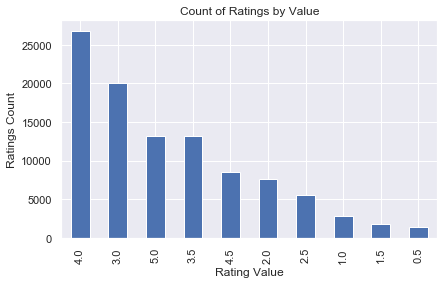

In [229]:

fig, ax = plt.subplots()
ax = ratings_df['rating'].value_counts().plot(kind='bar')
ax.set_xlabel('Rating Value')  # Add an x-label to the axes.
ax.set_ylabel('Ratings Count')  # Add a y-label to the axes.
ax.set_title("Count of Ratings by Value")  # Add a title to the axes.
plt.show()

*Observations:*

We can see that majority of the movies are rated either 3 or 4 out of 5 stars. It is important to note that movies with perfect ratings placed third.

**Rating Distribution**

Text(0, 0.5, 'Ratings Count')

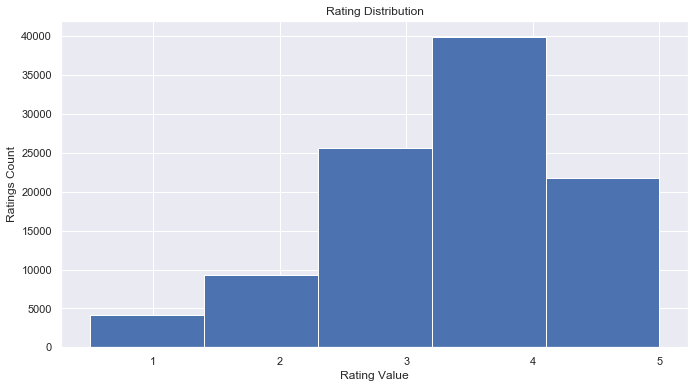

In [230]:
plt.figure(figsize=(10,6))
plt.hist(ratings_df['rating'], bins = 5)
plt.title('Rating Distribution')
plt.xlabel('Rating Value')
plt.ylabel('Ratings Count')

*Observations:*
    
We can see that majority of the movies are rated either 3 or 4 out of 5 stars. There are more perfectly rated movies versus those with the minimum rating.

### Users

**Distribution of User Behavior**

In [231]:
x = ratings_df['userId'].value_counts()
users = x.index[:]
counts = x.iloc[:]

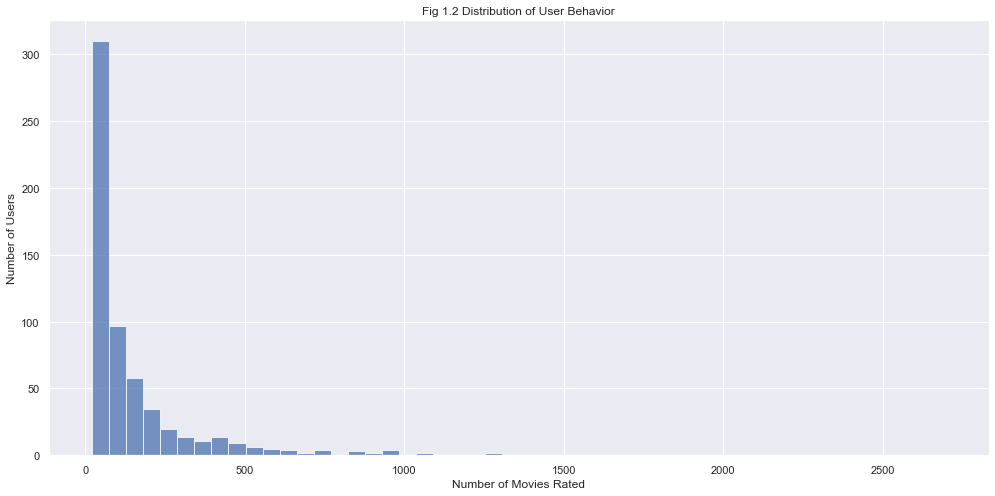

In [232]:
plt.figure(figsize=(15,8))
plt.hist(counts, 50, density=False, alpha=0.75)
plt.xlabel('Number of Movies Rated')
plt.ylabel('Number of Users')
plt.title('Fig 1.2 Distribution of User Behavior')
plt.grid(True)
plt.show()

*Observations:*

It is strange that the vast majority of the users have reviewed very few movies. Yet, there are outliers who have reviewed more than 2,000 movies. 

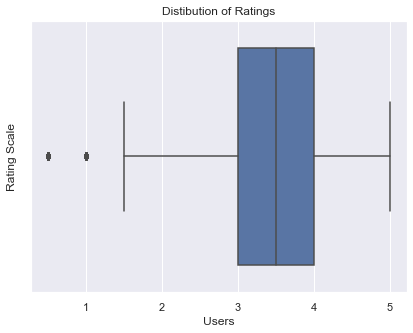

In [233]:
plt.figure(figsize=(6,5))
sns.boxplot(ratings_df['rating'])
plt.xlabel('Users')
plt.ylabel('Rating Scale')
plt.title('Distibution of Ratings')
plt.show()

*Observations:*

We see that the average rating is centred around the 3.5 and the interquartile range is between 3-4. A lot of movies have been highly rated.

### Genres

We now look into the different genres of the movies reviewed. In order to that, some pre-processing is necessary because each movie has multiple genres listed. This needs to be fleshed out.

In [234]:
def splitDataFrameList(df,target_column,separator):
    ''' df = dataframe to split,
    target_column = the column containing the values to split
    separator = the symbol used to perform the split
    returns: a dataframe with each entry for the target column separated, with each element moved into a new row. 
    The values in the other columns are duplicated across the newly divided rows.
    '''
    def splitListToRows(row,row_accumulator,target_column,separator):
        split_row = row[target_column].split(separator)
        for s in split_row:
            new_row = row.to_dict()
            new_row[target_column] = s
            row_accumulator.append(new_row)
    new_rows = []
    df.apply(splitListToRows,axis=1,args = (new_rows,target_column,separator))
    new_df = pd.DataFrame(new_rows)
    return new_df

In [236]:
genres_df = splitDataFrameList(df,"genres","|")

In [237]:
genres_df.head(5)

,userId,movieId,rating,timestamp,title,genres,imdbId,tmdbId,plot
0,1,1,4.0,964982703,Toy Story (1995),Adventure,114709,862.0,"Led by Woody, Andy's toys live happily in his ..."
1,1,1,4.0,964982703,Toy Story (1995),Animation,114709,862.0,"Led by Woody, Andy's toys live happily in his ..."
2,1,1,4.0,964982703,Toy Story (1995),Children,114709,862.0,"Led by Woody, Andy's toys live happily in his ..."
3,1,1,4.0,964982703,Toy Story (1995),Comedy,114709,862.0,"Led by Woody, Andy's toys live happily in his ..."
4,1,1,4.0,964982703,Toy Story (1995),Fantasy,114709,862.0,"Led by Woody, Andy's toys live happily in his ..."


In [238]:
genres_mean_df = genres_df.groupby('genres', as_index=False).agg({'rating': ['mean','count']})
genres_mean_df.columns = genres_mean_df.columns.droplevel(0)

In [239]:
genres_mean_df.columns = ['Genre', 'Mean', 'Count']
genres_mean_df = genres_mean_df.sort_values("Mean", ascending=False)

In [240]:
genres_mean_df.head(5)

,Genre,Mean,Count
10,Film-Noir,3.920115,870
18,War,3.808294,4859
7,Documentary,3.797785,1219
6,Crime,3.657980,17037
8,Drama,3.655642,42267


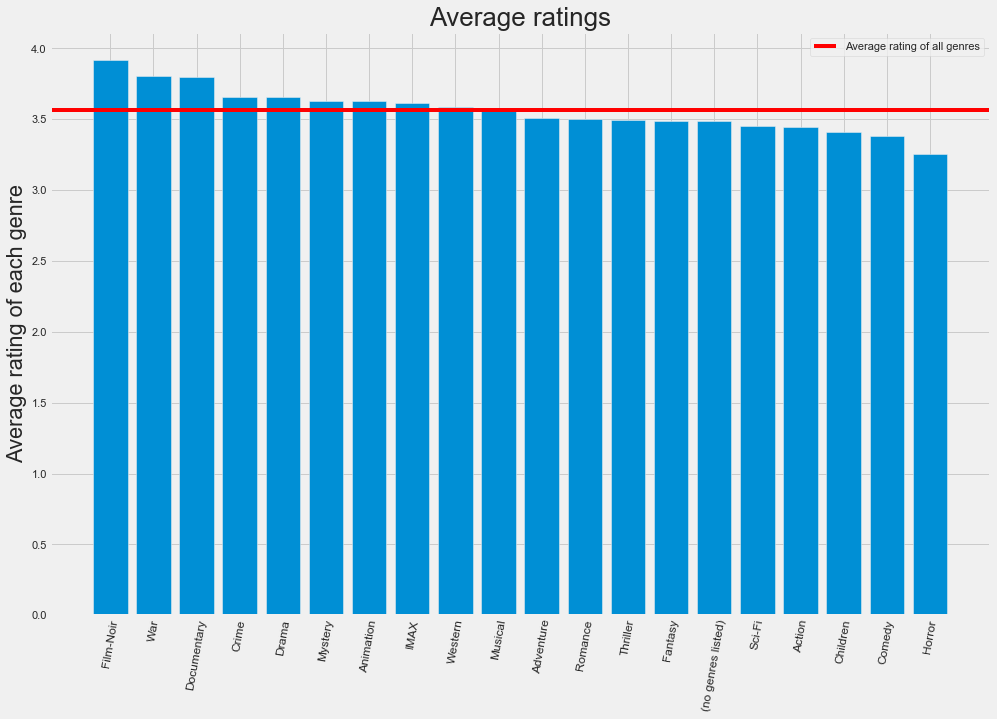

In [241]:
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 18})


fig, ax = plt.subplots(figsize=(15,10))

ax.bar(genres_mean_df["Genre"],genres_mean_df["Mean"])
ax.axhline(genres_mean_df["Mean"].mean(), color="red", label="Average rating of all genres")

ax.set_xticklabels(genres_mean_df["Genre"], rotation=80, fontsize=12)

ax.set_ylabel("Average rating of each genre")
ax.set_title('Average ratings')
ax.legend()

plt.show()

*Observations:*
    
Film-Noir genre has the highest rating of all genres followed by War, Documentary and Crime. Comedy and Horror are the last placers.

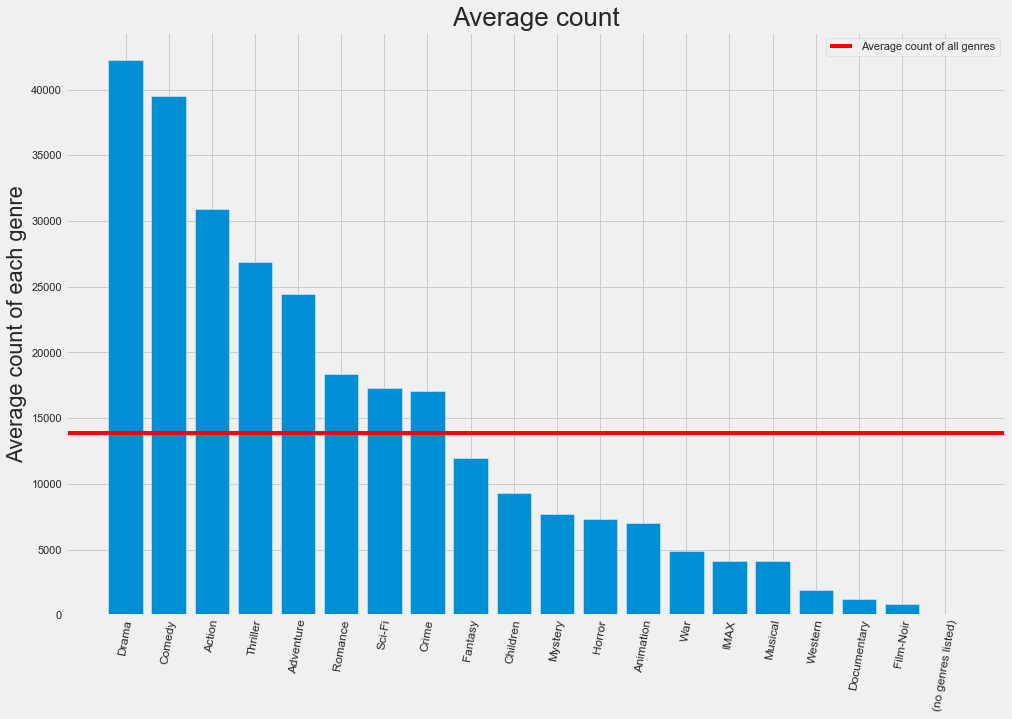

In [242]:
genres_mean_df = genres_mean_df.sort_values("Count", ascending=False)

plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 18})


fig, ax = plt.subplots(figsize=(15,10))

ax.bar(genres_mean_df["Genre"],genres_mean_df["Count"])
ax.axhline(genres_mean_df["Count"].mean(), color="red", label="Average count of all genres")

ax.set_xticklabels(genres_mean_df["Genre"], rotation=80, fontsize=12)

ax.set_ylabel("Average count of each genre")
ax.set_title('Average count')
ax.legend()

plt.show()

*Observations*

There are much more Drama movies reviewed versus other genres. The highest-reviewed genre has one of the fewest movies reviewed.

### Year

In [245]:
date = []
for i in tqdm(df['timestamp']):
    date.append(datetime.datetime.fromtimestamp(i).strftime('%Y'))

In [247]:
df['ratedYear'] = date
df.shape

(101951, 10)

In [249]:
z = df['ratedYear'].value_counts()
ycounts = z.iloc[:]
years = z.index[:]

In [250]:
year_df = pd.DataFrame({'Year':years,'counts':ycounts})
year_df.reset_index(drop =True)
year_df.sort_values(by=['Year'],inplace = True)

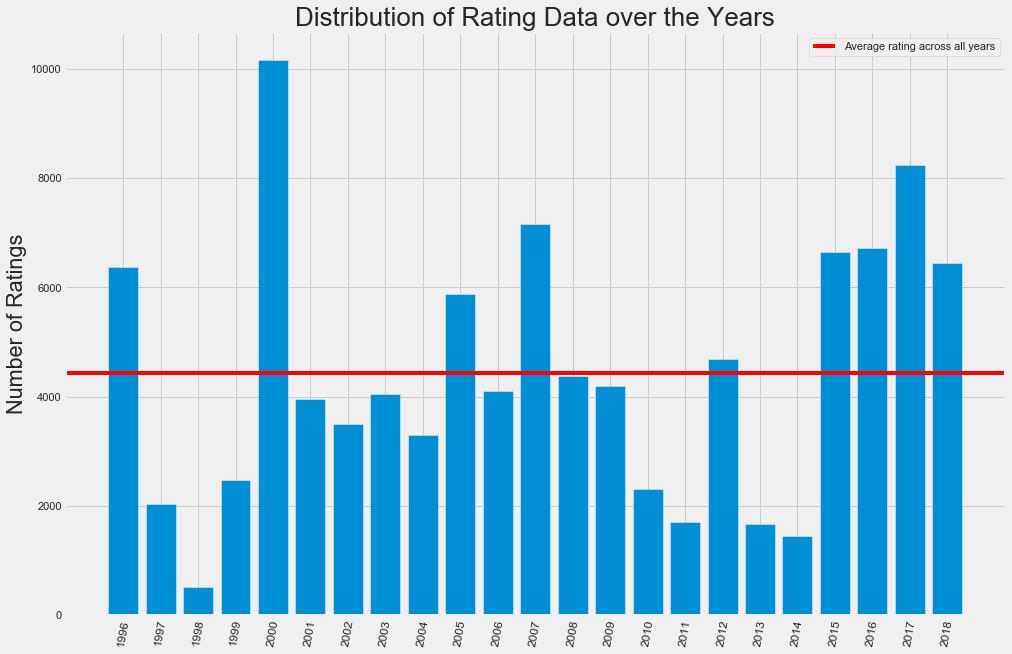

In [251]:
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 18})


fig, ax = plt.subplots(figsize=(15,10))

ax.bar(year_df.Year,year_df.counts )
ax.axhline(year_df.counts.mean(), color="red", label="Average rating across all years")

ax.set_xticklabels(year_df.Year, rotation=80, fontsize=12)

ax.set_ylabel("Number of Ratings")
ax.set_title("Distribution of Rating Data over the Years")
ax.legend()

plt.show()

*Observations:*

In this particular sample of dataset provided from Movielens, we see a sudden resurgence in the number of available ratings beginning from the year 2015.

### Popularity Index

In [252]:
pc = df['movieId'].value_counts()[:1000]
xax = list(range(0,1000))

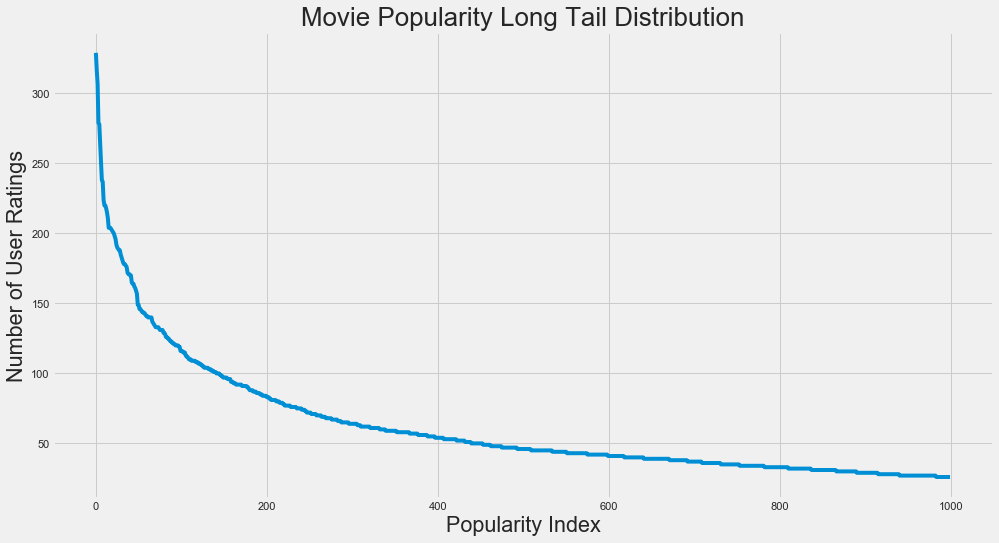

In [253]:
plt.figure(figsize=(15,8))
plt.plot(xax, pc)
plt.xlabel('Popularity Index')
plt.ylabel('Number of User Ratings')
plt.title('Movie Popularity Long Tail Distribution')
plt.show()

**Observations:**

The Popularity of Movies follow the long tail distibution which exemplifies the phenomenon of rich gets richer. More Popular movies get more ratings.

The need for Recommender Systems are represented by a concept called the "Long Tail," which is visualized in the figure above. In the context of movies, there are some movies that everyone is going to watch: A-list movies, superheroes etc. There are also movies that are far more obscure: indies and foreign films, low budget flicks etc. Recommendation systems are made to help consumers tap into this long tail to assist them in picking from the endless number of options that are made available to them via the internet.

## Collaborative Filtering

### Item-Item Filtering


ThepPivot table created below is used to map 1:1 relationship between movies, users and their ratings. By default, the pivot_table method takes average if there are multiple values of one combination.

In [269]:
ratings_matrix_items = df.pivot_table(index=['movieId'],columns=['userId'],values='rating').reset_index(drop=True)
ratings_matrix_items.fillna(0, inplace = True )
ratings_matrix_items.shape

(9724, 610)

In [270]:
ratings_matrix_items

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
0,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
1,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9722,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [271]:
movie_similarity = 1 - pairwise_distances( ratings_matrix_items.as_matrix(), metric="cosine" )
np.fill_diagonal( movie_similarity, 0 ) 
ratings_matrix_items = pd.DataFrame( movie_similarity )
ratings_matrix_items

,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
0,0.000000,0.410562,0.296917,0.035573,0.308762,0.376316,0.277491,0.131629,0.232586,0.395573,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.410562,0.000000,0.282438,0.106415,0.287795,0.297009,0.228576,0.172498,0.044835,0.417693,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.296917,0.282438,0.000000,0.092406,0.417802,0.284257,0.402831,0.313434,0.304840,0.242954,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.035573,0.106415,0.092406,0.000000,0.188376,0.089685,0.275035,0.158022,0.000000,0.095598,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.308762,0.287795,0.417802,0.188376,0.000000,0.298969,0.474002,0.283523,0.335058,0.218061,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
9720,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
9721,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
9722,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0


In [272]:
ratings_matrix_items['movie'] = movies_df['title']
ratings_matrix_items.set_index('movie', inplace = True)


In [273]:
ratings_matrix_items.head(5)

,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
movie,,,,,,,,,,,,,,,,,,,,,
Toy Story (1995),0.000000,0.410562,0.296917,0.035573,0.308762,0.376316,0.277491,0.131629,0.232586,0.395573,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Jumanji (1995),0.410562,0.000000,0.282438,0.106415,0.287795,0.297009,0.228576,0.172498,0.044835,0.417693,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grumpier Old Men (1995),0.296917,0.282438,0.000000,0.092406,0.417802,0.284257,0.402831,0.313434,0.304840,0.242954,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Waiting to Exhale (1995),0.035573,0.106415,0.092406,0.000000,0.188376,0.089685,0.275035,0.158022,0.000000,0.095598,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Father of the Bride Part II (1995),0.308762,0.287795,0.417802,0.188376,0.000000,0.298969,0.474002,0.283523,0.335058,0.218061,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [274]:
ratings_matrix_items.columns = ratings_matrix_items.index
ratings_matrix_items

movie,Toy Story (1995),Jumanji (1995),Grumpier Old Men (1995),Waiting to Exhale (1995),Father of the Bride Part II (1995),Heat (1995),Sabrina (1995),Tom and Huck (1995),Sudden Death (1995),GoldenEye (1995),...,Dogman (2018),Mamma Mia: Here We Go Again! (2018),Tag (2018),The Man Who Killed Don Quixote (2018),Boundaries (2018),Spiral (2018),Mission: Impossible - Fallout (2018),SuperFly (2018),Iron Soldier (2010),BlacKkKlansman (2018)
movie,,,,,,,,,,,,,,,,,,,,,
Toy Story (1995),0.000000,0.410562,0.296917,0.035573,0.308762,0.376316,0.277491,0.131629,0.232586,0.395573,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Jumanji (1995),0.410562,0.000000,0.282438,0.106415,0.287795,0.297009,0.228576,0.172498,0.044835,0.417693,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grumpier Old Men (1995),0.296917,0.282438,0.000000,0.092406,0.417802,0.284257,0.402831,0.313434,0.304840,0.242954,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Waiting to Exhale (1995),0.035573,0.106415,0.092406,0.000000,0.188376,0.089685,0.275035,0.158022,0.000000,0.095598,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Father of the Bride Part II (1995),0.308762,0.287795,0.417802,0.188376,0.000000,0.298969,0.474002,0.283523,0.335058,0.218061,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Spiral (2018),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
Mission: Impossible - Fallout (2018),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
SuperFly (2018),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0


In [275]:
ratings_matrix_items.iloc[9].sort_values(ascending=False).head(6)

movie
Die Hard: With a Vengeance (1995)    0.615794
True Lies (1994)                     0.576175
Clear and Present Danger (1994)      0.573650
Speed (1994)                         0.571704
Batman (1989)                        0.563148
Stargate (1994)                      0.562580
Name: GoldenEye (1995), dtype: float64

In [281]:
# create a box to let user input movie name (need a space after book name)
user_movie = str(input("Give a movie name?"))

Give a movie name?Batman (1989)


In [282]:
# create a function to return top 5 recommendations based on given movie
def get_rec(user_movie,ratings_matrix_items):
    for i in ratings_matrix_items.index:
        if user_movie == i:
            return ratings_matrix_items[user_movie].sort_values(ascending= False)[1:6]

In [283]:
# show recommendation results
print('Top 5 movie recommendations for you:')
print(get_rec(user_movie,ratings_matrix_items))

Top 5 movie recommendations for you:
movie
True Lies (1994)                     0.696755
Terminator 2: Judgment Day (1991)    0.645603
Fugitive, The (1993)                 0.639785
Jurassic Park (1993)                 0.639496
Dances with Wolves (1990)            0.599986
Name: Batman (1989), dtype: float64


### User-User Filtering

In this method, we recommend movies to a user based on his preferences compared to preferences of other users. This algorithm is very effective but takes a lot of time and resources. 

In [284]:
ratings_matrix_users = df.pivot_table(index=['userId'],columns=['movieId'],values='rating').reset_index(drop=True)
ratings_matrix_users.fillna( 0, inplace = True )
movie_similarity = 1 - pairwise_distances( ratings_matrix_users.as_matrix(), metric="cosine" )
np.fill_diagonal( movie_similarity, 0 ) #Filling diagonals with 0s for future use when sorting is done
ratings_matrix_users = pd.DataFrame( movie_similarity )
ratings_matrix_users

,0,1,2,3,4,5,6,7,8,9,...,600,601,602,603,604,605,606,607,608,609
0,0.000000,0.027283,0.059720,0.194395,0.129080,0.128152,0.158744,0.136968,0.064263,0.016875,...,0.080554,0.164455,0.221486,0.070669,0.153625,0.164191,0.269389,0.291097,0.093572,0.145321
1,0.027283,0.000000,0.000000,0.003726,0.016614,0.025333,0.027585,0.027257,0.000000,0.067445,...,0.202671,0.016866,0.011997,0.000000,0.000000,0.028429,0.012948,0.046211,0.027565,0.102427
2,0.059720,0.000000,0.000000,0.002251,0.005020,0.003936,0.000000,0.004941,0.000000,0.000000,...,0.005048,0.004892,0.024992,0.000000,0.010694,0.012993,0.019247,0.021128,0.000000,0.032119
3,0.194395,0.003726,0.002251,0.000000,0.128659,0.088491,0.115120,0.062969,0.011361,0.031163,...,0.085938,0.128273,0.307973,0.052985,0.084584,0.200395,0.131746,0.149858,0.032198,0.107683
4,0.129080,0.016614,0.005020,0.128659,0.000000,0.300349,0.108342,0.429075,0.000000,0.030611,...,0.068048,0.418747,0.110148,0.258773,0.148758,0.106435,0.152866,0.135535,0.261232,0.060792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,0.164191,0.028429,0.012993,0.200395,0.106435,0.102123,0.200035,0.099388,0.075898,0.088963,...,0.178084,0.116534,0.300669,0.066032,0.148141,0.000000,0.153063,0.262558,0.069622,0.201104
606,0.269389,0.012948,0.019247,0.131746,0.152866,0.162182,0.186114,0.185142,0.011844,0.010451,...,0.092525,0.199910,0.203540,0.137834,0.118780,0.153063,0.000000,0.283081,0.149190,0.139114
607,0.291097,0.046211,0.021128,0.149858,0.135535,0.178809,0.323541,0.187233,0.100435,0.077424,...,0.158355,0.197514,0.232771,0.155306,0.178142,0.262558,0.283081,0.000000,0.121993,0.322055
608,0.093572,0.027565,0.000000,0.032198,0.261232,0.214234,0.090840,0.423993,0.000000,0.021766,...,0.035653,0.335231,0.061941,0.236601,0.097610,0.069622,0.149190,0.121993,0.000000,0.053225



Here now we have similarity of users in colums with respective users in row. So if we find maximum value in a column we will get the user with highest similarity. So now we can have a pair of users which are similar.

In [285]:
ratings_matrix_users.idxmax(axis=1)

0      265
1      365
2      312
3      390
4      469
      ... 
605    473
606    569
607    479
608    339
609    248
Length: 610, dtype: int64

In [286]:
ratings_matrix_users.idxmax(axis=1).sample( 10, random_state = 42)

81     437
218    238
55      93
598    413
264    201
155    274
482     67
321    329
580    299
291     20
dtype: int64

In [287]:
similar_user_series= ratings_matrix_users.idxmax(axis=1)
df_similar_user= similar_user_series.to_frame()
df_similar_user.columns=['similarUser']
df_similar_user.head(5)

,similarUser
0,265
1,365
2,312
3,390
4,469


The function belows takes in a user id then looks at the similarUser dataframe to check the most similar user. Then this automatically outputs five recommendations that are highly-rated by the similar user.

In [292]:
def similar_user_rec(user_id):
    similar_user = df_similar_user['similarUser'].iloc[user_id]
    new_df = df.loc[(df['userId'] == similar_user)]
    new_df = new_df.sort_values('rating', ascending=False).head(5)
    rec_list = new_df['title'].to_list()
    print("Based on users with similar tastes, you will also like the following movies:")
    return rec_list[0:6]

In [293]:
similar_user_rec(581)

Based on users with similar tastes, you will also like the following movies:


['Immortals (2011)',
 'Watchmen (2009)',
 'Lord of the Rings: The Return of the King, The (2003)',
 'Matrix Revolutions, The (2003)',
 'Pirates of the Caribbean: The Curse of the Black Pearl (2003)']

### Memory-Based Methods (Neighborhood-Based)

The first thing we are going to do is build some baseline Collaborative Recommendation models. We will begin with Surprise and loading in our data. We'll first look at RMSE for evaluation but then expand to other metrics.

In [296]:
ratings_df.drop(columns='timestamp',inplace=True)

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_df, reader)

Let's look at how many users and items we have in our dataset. If using neighborhood-based methods, this will help us determine whether or not we should perform user-user or item-item similarity

In [297]:
dataset = data.build_full_trainset()
print('Number of users: ', dataset.n_users, '\n')
print('Number of items: ', dataset.n_items)

Number of users:  610 

Number of items:  9724


In [298]:
#Creating SVD Model and showing RMSE
params = {'n_factors': [20, 50, 100],
         'reg_all': [0.02, 0.05, 0.1]}
g_s_svd = GridSearchCV(SVD,param_grid=params,n_jobs=-1)
g_s_svd.fit(data)
print(g_s_svd.best_score)
print(g_s_svd.best_params)

{'rmse': 0.8692788245145655, 'mae': 0.6686461841600226}
{'rmse': {'n_factors': 100, 'reg_all': 0.05}, 'mae': {'n_factors': 100, 'reg_all': 0.05}}


In [300]:
sim_metrics = ['pearson','MSD','cosine','pearson_baseline']
#Creating Basic KNN Model and showing RMSE, checking all distance metrics
for metric in sim_metrics:
    knn_basic = KNNBasic(sim_options={'name': metric, 'user_based':True})
    cv_knn_basic = cross_validate(knn_basic, data, n_jobs=-1)
    print('Similarity Metric = ', metric,'---', 'test_rmse = ', np.mean(cv_knn_basic['test_rmse']),'\n')
    
    

Similarity Metric =  pearson --- test_rmse =  0.9733026479204131 

Similarity Metric =  MSD --- test_rmse =  0.9461929998797871 

Similarity Metric =  cosine --- test_rmse =  0.9719634322993 

Similarity Metric =  pearson_baseline --- test_rmse =  0.9709783855758932 



In [301]:
# cross validating with KNNBaseline
for metric in sim_metrics:
    knn_baseline = KNNBaseline(sim_options={'name':'pearson', 'user_based':True})
    cv_knn_baseline = cross_validate(knn_baseline,data)
    print('Similarity Metric = ', metric,'---', 'test_rmse = ', np.mean(cv_knn_baseline['test_rmse']),'\n')

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Similarity Metric =  pearson --- test_rmse =  0.8768820905317064 

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matri

### Trying hit rate as an evaluation

In [303]:
trainSet, testSet = train_test_split(data, test_size=.25, random_state=0)

In [304]:
#Get top 10 predictions for ratings above 4
def GetTopN(predictions, n=10, minimumRating=4.0):
    topN = defaultdict(list)
    for userID, movieID, actualRating, estimatedRating, _ in predictions:
        if (estimatedRating >= minimumRating):
            topN[int(userID)].append((int(movieID), estimatedRating))

    for userID, ratings in topN.items():
        ratings.sort(key=lambda x: x[1], reverse=True)
        topN[int(userID)] = ratings[:n]

    return topN
    
LOOCV = LeaveOneOut(n_splits=1, random_state=1)



In [305]:
#Get top predictions 
#When I use n=10 for knn it gets 0 hits, expanding to 50 it got a positive non-zero amount
#so I am confident it is working just doing a worse job likely due to sparseness. I expanded
#both to 50 for now
svd_model= SVD(n_factors=50,reg_all=0.05)
KNN_model= KNNBaseline(sim_options={'name':'pearson', 'user_based':True})

for trainSet, testSet in LOOCV.split(data):
    # Train model without left-out ratings
    svd_model.fit(trainSet)
    leftOutPredictionsSVD = svd_model.test(testSet)
    bigTestSet = trainSet.build_anti_testset()
    allPredictionsSVD = svd_model.test(bigTestSet)
    
    KNN_model.fit(trainSet)
    leftOutPredictionsKNN = KNN_model.test(testSet)
    bigTestSet = trainSet.build_anti_testset()
    allPredictionsKNN = KNN_model.test(bigTestSet)
   
  
    # Compute top 50 recs for each user
    topNPredictedSVD = GetTopN(allPredictionsSVD, n=50)
    topNPredictedKNN = GetTopN(allPredictionsKNN, n=50)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [306]:
def HitRate(topNPredicted, leftOutPredictions):
    hits = 0
    total = 0

 # For each left-out rating
    for leftOut in leftOutPredictions:
        userID = leftOut[0]
        leftOutMovieID = leftOut[1]
        # Is it in the predicted top 50 for this user?
        hit = False
        for movieID, predictedRating in topNPredicted[int(userID)]:
            if (int(leftOutMovieID) == int(movieID)):
                hit = True
                break
        if (hit) :
            hits += 1

        total += 1

    # Compute overall precision
    return hits/total


In [307]:
print("\nHit Rate SVD: ", HitRate(topNPredictedSVD, leftOutPredictionsSVD))
print("\nHit Rate KNN: ", HitRate(topNPredictedKNN, leftOutPredictionsKNN))


Hit Rate SVD:  0.07704918032786885

Hit Rate KNN:  0.003278688524590164


In [308]:
def RatingHitRate(topNPredicted, leftOutPredictions):
    hits = defaultdict(float)
    total = defaultdict(float)
    # For each left-out rating
    for userID, leftOutMovieID, actualRating, estimatedRating, _ in leftOutPredictions:
        # Is it in the predicted top N for this user?
        hit = False
        for movieID, predictedRating in topNPredicted[int(userID)]:
            if (int(leftOutMovieID) == movieID):
                hit = True
                break
        if (hit) :
            hits[actualRating] += 1
        total[actualRating] += 1

    # Compute overall precision
    for rating in sorted(hits.keys()):
        print(rating, hits[rating] / total[rating])

In [309]:
print("Hit Rate by Rating value SVD: ")
RatingHitRate(topNPredictedSVD, leftOutPredictionsSVD)

Hit Rate by Rating value SVD: 
1.5 0.1
2.0 0.022727272727272728
3.0 0.017391304347826087
3.5 0.041666666666666664
4.0 0.05555555555555555
4.5 0.16981132075471697
5.0 0.17886178861788618


In [314]:
print("Hit Rate by Rating value KNN: ")
RatingHitRate(topNPredictedKNN, leftOutPredictionsKNN)

Hit Rate by Rating value KNN: 
4.0 0.005555555555555556
5.0 0.008130081300813009


In [315]:
def CumulativeHitRate(topNPredicted, leftOutPredictions, ratingCutoff=0):
    hits = 0
    total = 0
    # For each left-out rating
    for userID, leftOutMovieID, actualRating, estimatedRating, _ in leftOutPredictions:
        # Only look at ability to recommend things the users actually liked...
        if (actualRating >= ratingCutoff):
            # Is it in the predicted top 10 for this user?
            hit = False
            for movieID, predictedRating in topNPredicted[int(userID)]:
                if (int(leftOutMovieID) == movieID):
                    hit = True
                    break
            if (hit) :
                hits += 1
            total += 1

        # Compute overall precision
    return hits/total

In [316]:
print("Cumulative Hit Rate SVD (rating >= 4): ", CumulativeHitRate(topNPredictedSVD, leftOutPredictionsSVD, 4.0))
print("Cumulative Hit Rate KNN(rating >= 4): ", CumulativeHitRate(topNPredictedKNN, leftOutPredictionsKNN, 4.0))



Cumulative Hit Rate SVD (rating >= 4):  0.1151685393258427
Cumulative Hit Rate KNN(rating >= 4):  0.0056179775280898875


In [317]:
def AverageReciprocalHitRank(topNPredicted, leftOutPredictions):
    summation = 0
    total = 0
        # For each left-out rating
    for userID, leftOutMovieID, actualRating, estimatedRating, _ in leftOutPredictions:
        # Is it in the predicted top N for this user?
        hitRank = 0
        rank = 0
        for movieID, predictedRating in topNPredicted[int(userID)]:
            rank = rank + 1
            if (int(leftOutMovieID) == movieID):
                hitRank = rank
                break
        if (hitRank > 0) :
                summation += 1.0 / hitRank

        total += 1

    return summation / total

In [318]:
print("Average Reciprocal Hit Rank SVD: ", AverageReciprocalHitRank(topNPredictedSVD, leftOutPredictionsKNN))
print("Average Reciprocal Hit Rank KNN: ", AverageReciprocalHitRank(topNPredictedKNN, leftOutPredictionsKNN))


Average Reciprocal Hit Rank SVD:  0.012752174495753494
Average Reciprocal Hit Rank KNN:  0.00017041000647558026


In [319]:
def dcg(scores):
    assert scores
    return scores[0] sum(sc / log(ind, 2) for sc, ind in zip(scores[1:], range(2, len(scores)+1)))

def ndcg(predicted_scores, user_scores):
    assert len(predicted_scores) == len(user_scores)
    idcg = dcg(sorted(user_scores, reverse=True))
    return (dcg(predicted_scores) / idcg) if idcg > 0.0 else 0.0

SyntaxError: invalid syntax (<ipython-input-319-50442dabde64>, line 3)

In [320]:
testRatings = []
for row in testSet:
    testRatings.append(row[2])
predRatingsSVD = []
for row in leftOutPredictionsSVD:
    predRatingsSVD.append(row[3])
predRatingsKNN = []
for row in leftOutPredictionsKNN:
    predRatingsKNN.append(row[3])

In [321]:
print('NDCG Value SVD:', ndcg(predRatingsSVD,testRatings))
print('NDCG Value KNN:', ndcg(predRatingsKNN,testRatings))

NameError: name 'ndcg' is not defined

In [313]:
dcg(testRatings)

NameError: name 'dcg' is not defined

In [ ]:
diff = []
for i in range(0,len(predRatingsSVD)):
    diff.append(abs(predRatingsSVD[i]-predRatingsKNN[i]))
np.mean(diff)

Its pretty clear that the SVD model is outperforming the KNN model here. It was slightly better using RMSE and is significantly better using a hit rate method.

## Make recommendations

In [ ]:
def movie_rec(movie_df,n_ratings=4, genre=None,n_recs=5):
    '''This function takes in the movies dataframe, number of new ratings, genre choice, and
    number of recommendations requested and returns that many reccomendations'''
    userID = 1000
    rating_list = []
    while n_ratings > 0:
        if genre:
            movie = movie_df[movie_df['genres'].str.contains(genre)].sample(1)
        else:
            movie = movie_df.sample(1)
        print(movie)
        rating = input('How do you rate this movie on a scale of 1-5, press n if you have not seen :\n')
        if rating == 'n':
            continue
        else:
            rating_one_movie = {'userId':userID,'movieId':movie['movieId'].values[0],'rating':rating}
            rating_list.append(rating_one_movie) 
            n_ratings -= 1
    ratings_df2 = ratings_df.append(rating_list,ignore_index=True)
    new_data = Dataset.load_from_df(ratings_df2,reader)
    svd_model= SVD(n_factors=50,reg_all=0.05)
    svd_model.fit(new_data.build_full_trainset())
# make predictions for the user
# you'll probably want to create a list of tuples in the format (movie_id, predicted_score)
    list_of_movies = []
    for m_id in ratings_df2['movieId'].unique():
        list_of_movies.append( (m_id,svd_model.predict(1000,m_id)[3]))
    
# order the predictions from highest to lowest rated
    ranked_movies = sorted(list_of_movies, key=lambda x:x[1], reverse=True)
    for idx, rec in enumerate(ranked_movies):
            title = movies_df.loc[movies_df['movieId'] == int(rec[0])]['title']
            print('Recommendation # ', idx+1, ': ', title, '\n')
            n_recs-= 1
            if n_recs == 0:
                break

In [ ]:
n_ratings=4
n_recs=10

In [ ]:
movie_rec(movies_df, n_ratings,'Comedy',n_recs)

In [323]:
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [325]:
# First train an SVD algorithm on the movielens dataset.
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_df, reader)
trainset = data.build_full_trainset()
algo = SVD()
algo.fit(trainset)

In [326]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

top_n = get_top_n(predictions, n=10)

In [327]:
# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

1 [318, 112552, 720, 475, 904, 1266, 4226, 922, 5902, 858]
2 [1089, 608, 541, 2959, 356, 951, 1201, 1199, 3275, 296]
3 [296, 3451, 1262, 30707, 4011, 3468, 908, 1136, 109374, 1267]
4 [1244, 1208, 3037, 27773, 2300, 140110, 1262, 2804, 318, 1204]
5 [858, 4993, 2959, 1221, 260, 750, 2019, 4011, 47, 741]
6 [720, 2571, 1387, 1213, 908, 1272, 3578, 1237, 3451, 1193]
7 [1136, 2571, 1204, 5418, 1223, 457, 7361, 60069, 88810, 174053]
8 [1204, 4973, 898, 922, 48516, 1104, 1203, 142488, 4878, 910]
9 [1210, 1196, 2160, 527, 260, 1197, 1213, 1234, 296, 1719]
10 [898, 54001, 1035, 1215, 919, 3086, 2804, 246, 78499, 48516]
11 [904, 260, 778, 1204, 1252, 50, 296, 741, 1213, 2324]
12 [110, 457, 1089, 1197, 1198, 1213, 1278, 2329, 2502, 2997]
13 [260, 1196, 1197, 858, 318, 27773, 2959, 904, 3275, 1213]
14 [1204, 58, 3468, 50, 904, 246, 142488, 7153, 1250, 1276]
15 [110, 1387, 246, 51255, 1704, 1213, 6283, 1036, 1199, 48516]
16 [1104, 720, 48516, 81845, 106642, 1204, 930, 54997, 1212, 142488]
17 [1203, 

In [328]:
top_n

defaultdict(list,
            {1: [(318, 5),
              (112552, 5),
              (720, 5),
              (475, 5),
              (904, 5),
              (1266, 5),
              (4226, 5),
              (922, 5),
              (5902, 5),
              (858, 5)],
             2: [(1089, 4.4843500610173646),
              (608, 4.459192113428479),
              (541, 4.404882453460713),
              (2959, 4.403449044199956),
              (356, 4.398022929598312),
              (951, 4.394214734475031),
              (1201, 4.382554872586844),
              (1199, 4.379236314202514),
              (3275, 4.36889435140152),
              (296, 4.357376350627269)],
             3: [(296, 3.6488577295256714),
              (3451, 3.6453488054944736),
              (1262, 3.604025216970377),
              (30707, 3.564323799206302),
              (4011, 3.5570689502709274),
              (3468, 3.5558298341665493),
              (908, 3.535009940880647),
              (1136, 3.5269339